# Points

Points are spatial entities that can be understood in two fundamentally different ways. On the one hand, points can be seen as fixed objects in space, which is to say their location is taken as given (*exogenous*). In this case, analysis of points is very similar to that of other types of spatial data such as polygons and lines. On the other hand, points can be seen as the occurence of an event that could theoretically take place anywhere but only manifests in certain locations. This is the approach we will adopt in the rest of the notebook.

When points are seen as events that could take place in several locations but only happen in a few of them, a collection of such events is called a *point pattern*. In this case, the location of points is one of the key aspects of interest for analysis. A good example of a point pattern is crime events in a city: they could technically happen in many locations but we usually find crimes are committed only in a handful of them. Point patterns can be *marked*, if more attributes are provided with the location, or *unmarked*, if only the coordinates of where the event occured are provided. Continuing the crime example, an unmarked pattern would result if only the location where crimes were committed was used for analysis, while we would be speaking of a marked point pattern if other attributes, such as the type of crime, the extent of the damage, etc. was provided with the location.

Point pattern analysis is thus concerned with the description, statistical characerization, and modeling of point patterns, focusing specially on the generating process that gives rise and explains the observed data. *What's the nature of the distribution of points?* *Is there any structure we can statistically discern in the way locations are arranged over space?* *Why do events occur in those places and not in others?* These are all questions that point pattern analysis is concerned with.

This notebook aims to be a gentle introduction to working with point patterns in Python. As such, it covers how to read, process and transform point data, as well as several common ways to visualize point patterns.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import dbscan
from ipywidgets import interact, fixed

/home/dani/anaconda/envs/gds/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data

We are going to dip our toes in the lake of point data by looking at a sample of geo-referenced tweets in the city of Liverpool. The dataset we will be playing with contains the location of over 130,000 messages posted on Twitter from January to the end of October of 2012. A detailed description of the variables included is provided in the "Datasets" section of the course website, as well as instructions to download it.

Once you have downloaded it and extracted the compressed `.zip` file, let us first set the paths to the shapefile. In addition, we will also be using the LSOA Census and geography dataset we already know, so let us add the path in advance to make things easier later on:

<!--
dates = tw.YEAR.apply(str) + '-' + (tw.MONTH+1).apply(str) + '-' + \
        tw.DAY.apply(str) + ' ' + \
        tw.HOUR.apply(str) + ':' + tw.MINUTE.apply(str)
dates = dates.apply(pd.to_datetime)
dates.head()
-->

In [2]:
# This will be different on your computer and will depend on where
# you have downloaded the files

# Twitter dataset
tw_path = '../../../../data/tweets_liverpool/tweets_liverpool.shp'
# LSOAs polygons
lsoas_path = '../../../../data/Liverpool/shapefiles/Liverpool_lsoa11.shp'
# Total population counts from Census Geodata Pack
pop_path = '../../../../data/Liverpool/tables/CT0010_lsoa11.csv'

**IMPORTANT**: the paths above might have look different in your computer. See [this introductory notebook](begin.html) for more details about how to set your paths.

Since the data are stored in a shapefile, loading it is in the same way as usual:

In [3]:
%%time
# Read the file
tw = gpd.read_file(tw_path)
# Create a brief summary of the columns in the table
tw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 131209 entries, 0 to 131208
Data columns (total 12 columns):
DAY         131209 non-null int64
DOW         131209 non-null int64
HOUR        131209 non-null int64
LAT         131209 non-null float64
LON         131209 non-null float64
LSOA11CD    131209 non-null object
MINUTE      131209 non-null int64
MONTH       131209 non-null int64
X           131209 non-null float64
Y           131209 non-null float64
YEAR        131209 non-null int64
geometry    131209 non-null object
dtypes: float64(4), int64(6), object(2)
memory usage: 12.0+ MB
CPU times: user 7.4 s, sys: 116 ms, total: 7.52 s
Wall time: 7.52 s


Note how we have also added the command `%%time` at the top of the cell. Once the cell has run, this provides an accurate measurement of the time it took the computer to run the code. We are adding this because, as you can see in the description of the columns, this is a fairly large table, with 131,209 rows.

Depending on the running time of the cell above, it is recommended you do not use the full dataset but instead you shorten it and consider only a random sample of tweets (which retains the same properties). If it took your computer longer than 20 seconds to read the file (as indicated at the end of the cell output, `total`), you are strongly encouraged to subset your data by taking a random sample. This will make the rest of the analysis run much more smoothly on your computer and will result in a better experience. See below for details on how to do this.

### Random sample of tweets

Once we have loaded the data, taking a random sample is a relative simple operation. Let us first perform the computations and then delve into the steps, one by one.

In [4]:
# Set the "seed" so every run produces the generates the same random numbers
np.random.seed(1234)
# Create a sequence of length equal to the number of rows in the table
ri = np.arange(len(tw))
# Randomly reorganize (shuffle) the values
np.random.shuffle(ri)
# Reindex the table by using only the first 10,000 numbers 
# of the (now randomly arranged) sequence
tw = tw.iloc[ri[:10000], :]
# Display summary of the new table
tw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10000 entries, 50049 to 86084
Data columns (total 12 columns):
DAY         10000 non-null int64
DOW         10000 non-null int64
HOUR        10000 non-null int64
LAT         10000 non-null float64
LON         10000 non-null float64
LSOA11CD    10000 non-null object
MINUTE      10000 non-null int64
MONTH       10000 non-null int64
X           10000 non-null float64
Y           10000 non-null float64
YEAR        10000 non-null int64
geometry    10000 non-null object
dtypes: float64(4), int64(6), object(2)
memory usage: 1015.6+ KB


Let us walk through the strategy taken to randomly sample the table:

* First we create a separate sequence of numbers starting from zero (Python always starts counting on zero, not one) as long as the number of rows in the table we want to subset. At this point, this list starts on 0, then 1, 2, 3, 4, 5, ..., $N$-1 (with $N$ the length of the table, that is 131,209).
* Then, in line 4, the list is randomly rearranged. After this, the length is still the same -131,209- but the order has changed from the original sequence to a completely random one.
* At this point, we can subset the table, which we do in line 7. This command is composed of two elements: one (`ri[:10000]`) in which we keep only the first 10,000 elements of the randomly ordered list (if you wanted to subset the table to have a different number of observations, change that in here); the second (`tw.iloc`) is a standard subsetting query as we have been doing so far. 

The trick here is that by querying the table on the subset of 10,000 numbers obtained from a random draw of the entire set, we are only keeping the rows indexed on those numbers. This attains two things: one, it returns only 10,000 observations instead of the total 131,209; two, the subset that it does keep is entirely random, as the index used for it has been randomly "shuffled".

## Visualization of a Point Pattern

We will spend the rest of this notebook learning different ways to visualize a point pattern. In particular, we will consider to main strategies: one relies on aggregating the points into polygons, while the second one is based on creating continuous surfaces using kernel density estimation.

### Points meet polygons

Having learned about visualization of lattice (polygon) data, the most straightforward way to visualize point patterns is to "turn" them into polygons and apply techniques like choropleth mapping to visualize their spatial distribution. To do that, we will overlay a polygon layer on top of the point pattern, *join* the points to the polygons by assigning to each point the polygon where they fall into, and create a choropleth of the counts by polygon. This approach is very intuitive but of course raises the following question: *what polygons do we use to aggregate the points?* Ideally, we want a boundary delineation that matches as closely as possible the point generating process and partitions the space into areas with a similar internal intensity of points. However, that is usually not the case, no less because one of the main reasons we typically want to visualize the point pattern is to learn about such generating process, so we would typically not know a priori whether a set of polygons match it. If we cannot count on the ideal set of polygons to begin with, we can adopt two more realistic approaches: using a set of pre-existing irregular areas or create a artificial set of regular polygons.

#### Irregular lattices

To exemplify this approach, we will use the areas of the LSOAs that we have been working with throughout the course. So, before anything else, let us load them up into an object we will call `lsoas`:

In [5]:
lsoas = gpd.read_file(lsoas_path).set_index('LSOA11CD')

The next step we require is to assign to each tweet the LSOA where it was posted from. This can be done through a standard GIS operation called point-in-polygon. For the sake of keeping the focus on the visualization of points, the tweet dataset already includes the LSOA identifier where each tweet falls into in the column `LSOA11CD`. However, if you were exploring a brand new dataset and had to join it by yourself, you could to this in QGIS using the point-in-polygon tool available on the Vector menu (`Vector` --> `Data Management Tools` --> `Join Attributes by Location`). Alternatively, you could also perform this operation using `geopandas` and its "spatial join" extension. Although the latter is a bit more involved and advanced, it is also more efficient and fast.

Once we have the ID of the polygon where each tweet falls into, creating the count of tweets by polygon is one line of code away. Again, we rely on the `groupby` operator which takes all the tweets in the table and "groups" them "by" their LSOA code. Once grouped, we apply the method `size`, which counts how many elements each group has and returns a column indexed on the LSOA code with all the counts as its values. To make the mapping easier, we also assign the counts to a newly created column in the `lsoas` table.

In [6]:
# Create counts
tw_lsoa = tw.groupby('LSOA11CD').size()
# Assign counts into a column in the LSOAS table
lsoas['tweet_count'] = tw_lsoa

At this point, we are ready to map the counts. Technically speaking, this is a choropleth just as we have seen many times before (see Lab 4 if you need a refresher):

/home/dani/anaconda/envs/gds/lib/python2.7/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


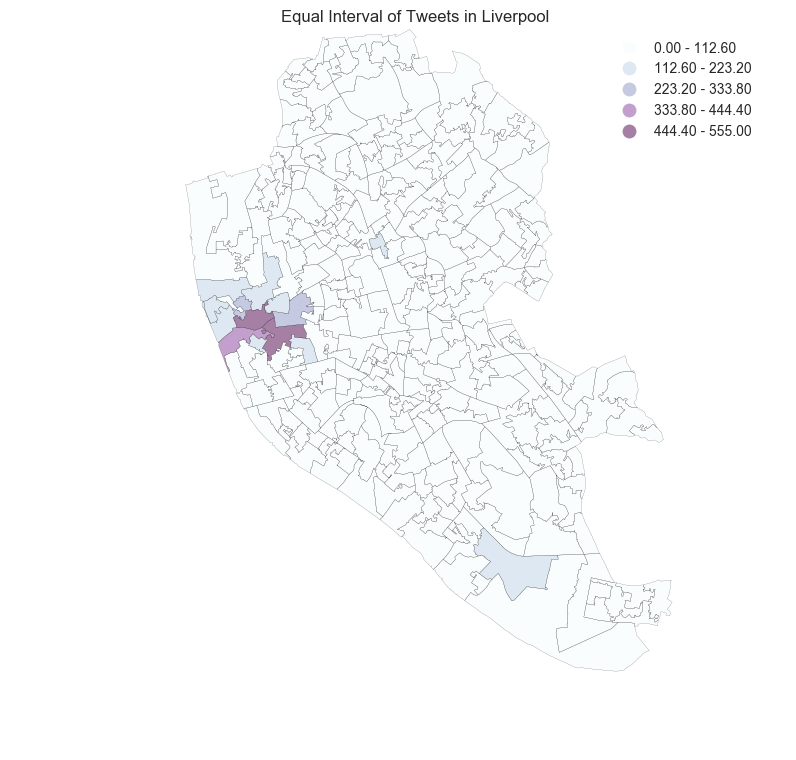

In [7]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the equal interval choropleth and add a legend
lsoas.plot(column='tweet_count', scheme='equal_interval', legend=True, \
           ax=ax, cmap='BuPu', linewidth=0.1)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Equal Interval of Tweets in Liverpool")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

---

**[Optional exercise]**

Create a similar choropleth as above but use a quantile or Fisher-Jenks classification instead of equal interval. What are the main differences? Why do you think this is the case? How does it relate to the distribution of counts by polygons?

<!--
f, ax = plt.subplots(1, figsize=(9, 9))
lsoas.plot(column='tweet_count', scheme='quantiles', legend=True, \
           axes=ax, colormap='BuPu', linewidth=0.1)
ax.set_axis_off()
ax.set_title("Quantile Tweets in Liverpool")
plt.axis('equal')
plt.show()
-->

---

The map above clearly shows a concentration of tweets in the city centre of Liverpool. However, it is important to remember that the map is showing *raw* counts of tweets. At this point it is useful to remember what we discussed in Labs 3 and 4 about mapping raw counts. In the case to tweets, as with many other phenomena that affect to only a portion of the population, it is crucial to keep in mind the underlying population. Although tweets could theoretically take place anywhere on the map, they really can only appear in areas where there are people who can post the messages. If population is not distributed equally (and most often it is not) and we ignore its spatial pattern, the map of raw counts will most likely simply display the overall pattern of the underlying population. In this example, if all we map is raw counts of tweets, we are showing a biased picture towards areas with high levels of population because, everything else equal, the more people the more potential for tweets to appear. 

To obtain a more accurate picture, what we would like to see is a map of the *intensity* of tweets, not of raw counts. To do this, ideally we want to divide the number of tweets per polygon by the total number of potential population who could tweet at any given moment. This of course is not always available, so we have to resort to proxy variables. For the sake of this example, we will use the residential population. Let us first load it up:

In [8]:
# Load table with population counts (and other variables too)
pop = pd.read_csv(pop_path, index_col=0)
# Total Population is `CT00100001`
pop = pop['CT00100001']
pop.head()

GeographyCode
E01006512    1880
E01006513    2941
E01006514    2108
E01006515    1208
E01006518    1696
Name: CT00100001, dtype: int64

Now we can insert it as a new column in the `lsoas` table:

In [9]:
lsoas['Total_Pop'] = pop

At this point, we can easily calculate the ratio of tweets per resident of each of the areas:

In [10]:
lsoas['tweet_int'] = lsoas['tweet_count'] / lsoas['Total_Pop']
lsoas.head()

,geometry,tweet_count,Total_Pop,tweet_int
LSOA11CD,,,,
E01006512,"POLYGON ((336103.358 389628.58, 336103.416 389...",171.0,1880,0.090957
E01006513,"POLYGON ((335173.781 389691.538, 335169.798 38...",494.0,2941,0.167970
E01006514,"POLYGON ((335495.676 389697.267, 335495.444 38...",101.0,2108,0.047913
E01006515,"POLYGON ((334953.001 389029, 334951 389035, 33...",47.0,1208,0.038907
E01006518,"POLYGON ((335354.015 388601.947, 335354 388602...",15.0,1696,0.008844


With the intensity at hand, creating the new choropleth takes exactly the same as above:

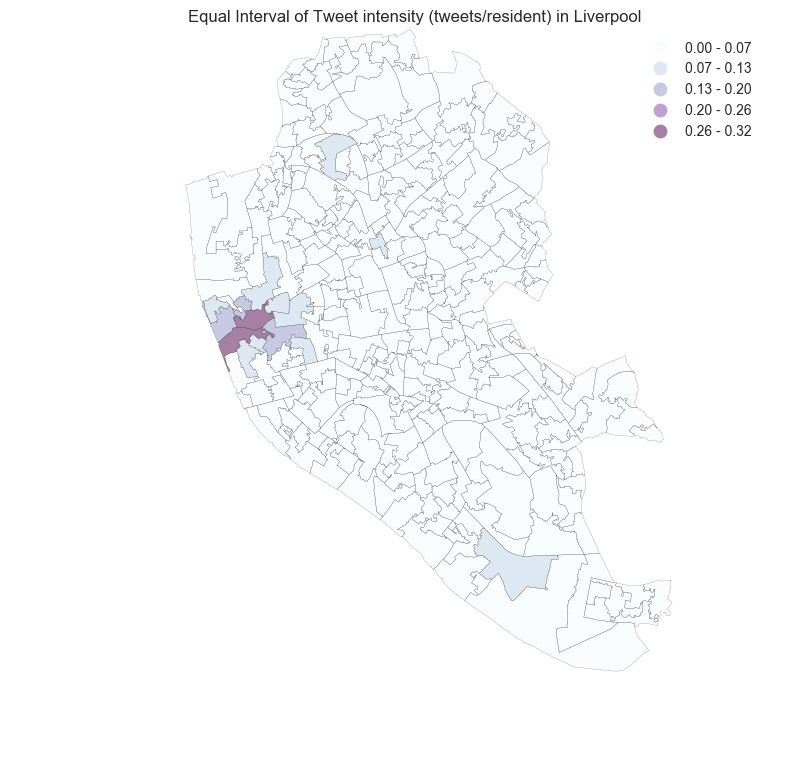

In [11]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the equal interval choropleth and add a legend
lsoas.plot(column='tweet_int', scheme='equal_interval', legend=True, \
           ax=ax, cmap='BuPu', linewidth=0.1)
# Remove the axes
ax.set_axis_off()
# Set the title
ax.set_title("Equal Interval of Tweet intensity (tweets/resident) in Liverpool")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

In this case, the pattern in the raw counts is so strong that the adjustment by population does not have a huge effect, but in other contexts mapping rates can yield very different results than mapping simple counts.

---

**[Optional exercise]**

Create a similar choropleth as above but use a quantile or Fisher-Jenks classification instead of equal interval. What are the main differences? Why do you think this is the case? How does it relate to the distribution of counts by polygons?

<!--
f, ax = plt.subplots(1, figsize=(9, 9))
lsoas.plot(column='tweet_count', scheme='quantiles', legend=True, \
           axes=ax, colormap='BuPu', linewidth=0.1)
ax.set_axis_off()
ax.set_title("Quantile Tweets in Liverpool")
plt.axis('equal')
plt.show()
-->

---

#### Regular lattices: hex-binning

Sometimes we either do not have any polygon layer to use or the ones we have are not particularly well suited to aggregate points into them. In these cases, a sensible alternative is to create an artificial topology of polygons that we can use to aggregate points. There are several ways to do this but the most common one is to create a grid of hexagons. This provides a regular topology (every polygon is of the same size and shape) that, unlike circles, cleanly exhausts all the space without overlaps and has more edges than squares, which alleviates edge problems.

Python has a simplified way to create this hexagon layer *and* aggregate points into it in one shot thanks to the method `hexbin`, which is available in every axis object (e.g. `ax`). Let us first see how you could create a map of the hexagon layer alone:

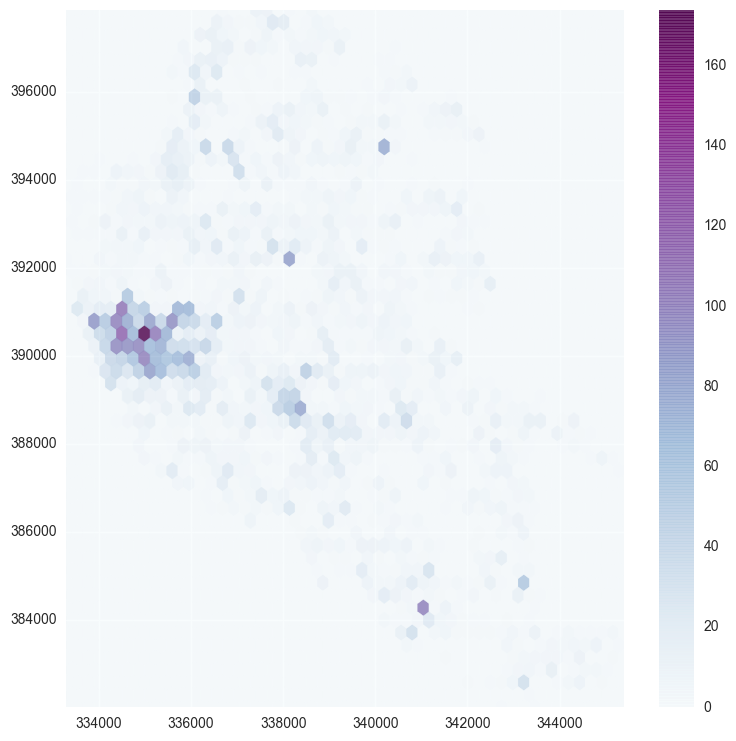

In [12]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(tw.X, tw.Y, gridsize=50, alpha=0.8, cmap='BuPu')
# Add a colorbar (optional)
plt.colorbar(hb)

See how all it takes is to set up the figure and call `hexbin` directly using the set of coordinate columns (`tw.X` and `tw.Y`). Additional arguments we include is the number of hexagons by axis (`gridsize`, 50 for a 50 by 50 layer), the transparency we want (80%), and the colormap of our choice (`BuPu` in our case). Additionally, we include a colorbar to get a sense of what colors imply. Note that we need to pass the name of the object that includes the `hexbin` (`hb` in our case), but keep in mind this is optional, you do not need to always create one.

Once we know the basics, we can insert it into the usual plotting routine we have been using to generate a complete hex-bin map of tweets in Liverpool:

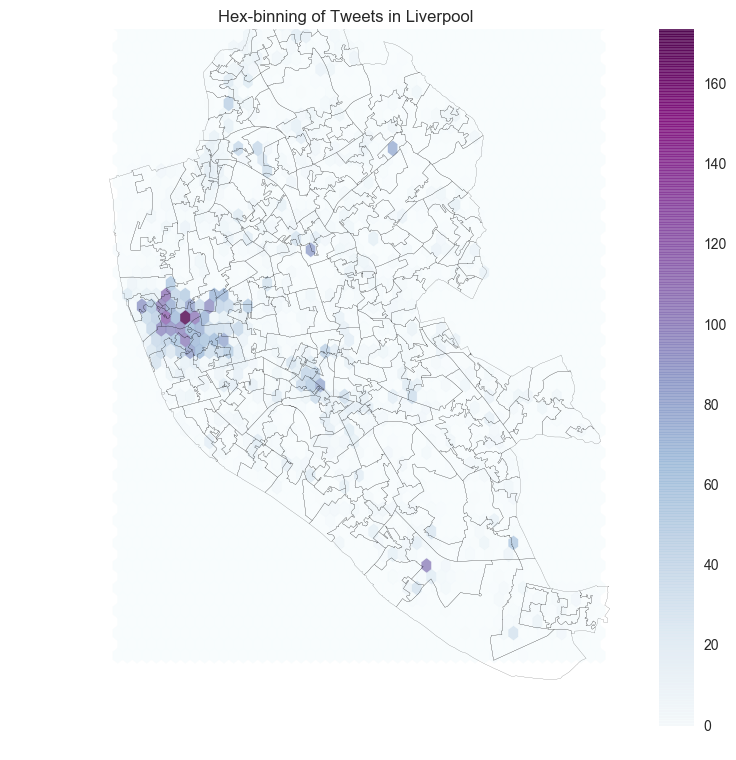

In [13]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add a base layer with the LSOA geography
lsoas.plot(ax=ax, facecolor='white', alpha=0, linewidth=0.1)
# Add hexagon layer that displays count of points in each polygon
hb = ax.hexbin(tw.X, tw.Y, gridsize=50, alpha=0.8, cmap='BuPu')
# Add a colorbar (optional)
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()
# Add title of the map
ax.set_title("Hex-binning of Tweets in Liverpool")
# Keep map proportionate
plt.axis('equal')
# Draw the map
plt.show()

### Kernel Density Estimation

**NOTE**: It is recommended that, for this section, you use the random subset of tweets rather than the entire batch of 131,209.

Using a hexagonal binning can be a quick solution when we do not have a good polygon layer to overlay the points directly and some of its properties, such as the equal size of each polygon, can help alleviate some of the problems with a "bad" irregular topology (one that does not fit the underlying point generating process). However, it does not get around the issue of the modifiable areal unit problem (M.A.U.P., see Lecture 4): at the end of the day, we are still imposing arbitrary boundary lines and aggregating based on them, so the possibility of mismatch with the underlying distribution of the point pattern is very real.

One way to work around this problem is to avoid aggregating altogether. Instead, we can aim at estimating the *continuous* observed probability distribution. The most commonly used method to do this is the so called *kernel density estimate* (KDE). The idea behind KDEs is to count the number of points in a *continious* way. Instead of using discrete counting, where you include a point in the count if it is inside a certain boundary and ignore it otherwise, KDEs use functions (kernels) that include points but give different weights to each one depending of how far of the location where we are counting the point is.

The actual algorithm to estimate a kernel density is not trivial but its application in Python is extremely simplified by the use of Seaborn's `kdeplot` command. Same as above, let us first see how to create the simplest possible KDE and then we will create a full-fledge map.

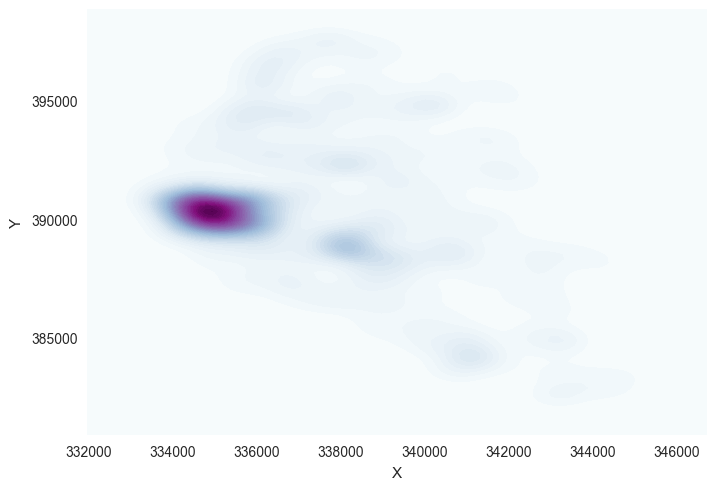

In [14]:
sns.kdeplot(tw['X'], tw['Y'], n_levels=50, shade=True, cmap='BuPu')

Seaborn greatly streamlines the process and boils it down to a single line. The method `sns.kdeplot` (which we can also use to create a KDE of a single variable) takes the X and Y coordinate of the points as the only compulsory attributes. In addition, we specify the number of levels we want the color gradient to have (`n_levels`), whether we want to color the space in between each level (`share`, yes), and the colormap of choice.

Once we know how the basic logic works, we can insert it into the usual mapping machinery to create a more complete plot. The main difference here is that we now have to tell `sns.kdeplot` where we want the surface to be added (`ax` in this case).

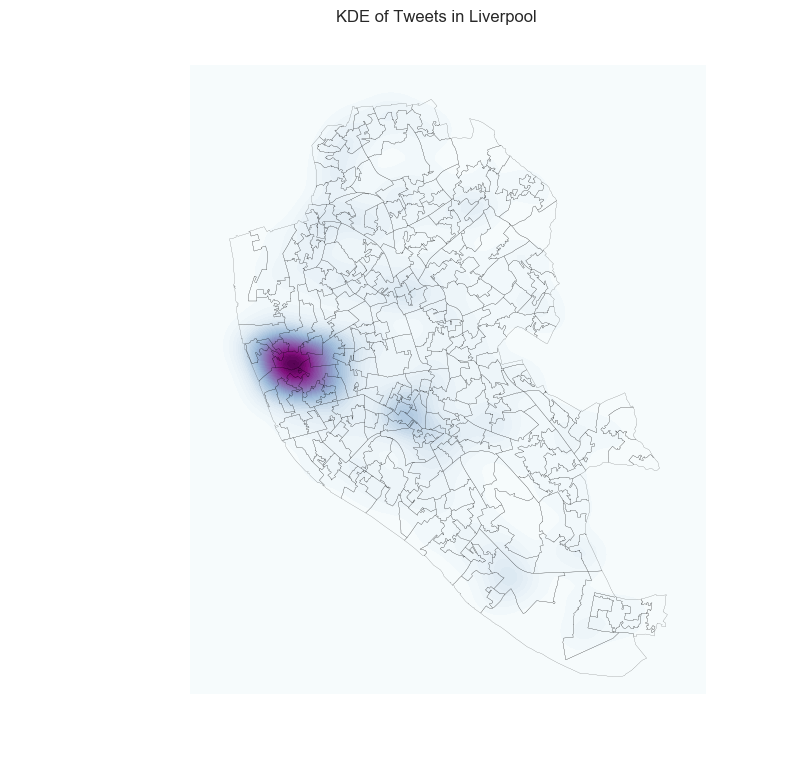

In [15]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Add a base layer with the LSOA geography
lsoas.plot(ax=ax, facecolor='white', alpha=0, linewidth=0.1)
# Generate KDE
sns.kdeplot(tw['X'], tw['Y'], ax=ax, \
            n_levels=50, shade=True, cmap='BuPu')
# Remove axes
ax.set_axis_off()
# Add title
ax.set_title("KDE of Tweets in Liverpool")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

## Clusters of points

In this final section, we will learn a method to identify clusters of points, based on their density across space. To do this, we will use the widely used `DBSCAN` algorithm. For this method, a cluster is a concentration of at least `m` points, each of them within a distance of `r` of at least another point in the cluster. Points in the dataset are then divided into three categories:

* *Noise*, for those points outside a cluster.
* *Cores*, for those points inside a cluster whith at least `m` points in the cluster within distance `r`.
* *Borders* for points inside a cluster with less than `m` other points in the cluster within distance `r`.

Both `m` and `r` need to be prespecified by the user before running `DBSCAN`. This is a critical point, as their value can influence significantly the final result. Before exploring this in greater depth, let us get a first run at computing `DBSCAN` in Python.

### Basics

The heavy lifting is done by the method `dbscan`, part of the excellent machine learning library `scikit-learn`. In fact, computing the clusters is only one line of code away:

In [16]:
# Compute DBSCAN
cs, lbls = dbscan(tw[['X', 'Y']])

The function returns two objects, which we call `cs` and `lbls`. `cs` contains the indices (order, starting from zero) of each point which is classified as a *core*. We can have a peek into it to see what it looks like:

In [17]:
# Print the first 5 elements of `cs`
cs[:5]

array([112, 114, 273, 341, 393])

The printout above tells us that the 113th (remember, Python starts counting at zero!) point in the dataset is a core, as it is the 115th, 274rd, 341st, and 393rd. The object `cs` always has a variable length, depending on how many cores the algorithm finds.

Now let us have a look at `lbls`, short for labels:

In [18]:
lbls[:5]

array([-1, -1, -1, -1, -1])

The labels object always has the same length as the number of points used to run `DBSCAN`. Each value represents the index of the cluster a point belongs to. If the point is classified as *noise*, it receives a -1. Above, we can see that the first five points are effectively not part of any cluster. To make thinks easier later on, let us turn `lbls` into a `Series` object that we can index in the same way as our collection of points:

In [19]:
lbls = pd.Series(lbls, index=tw.index)

Now we already have the clusters, we can proceed to visualize them. There are many ways in which this can be done. We will start just by coloring points in a cluster in red and noise in grey:

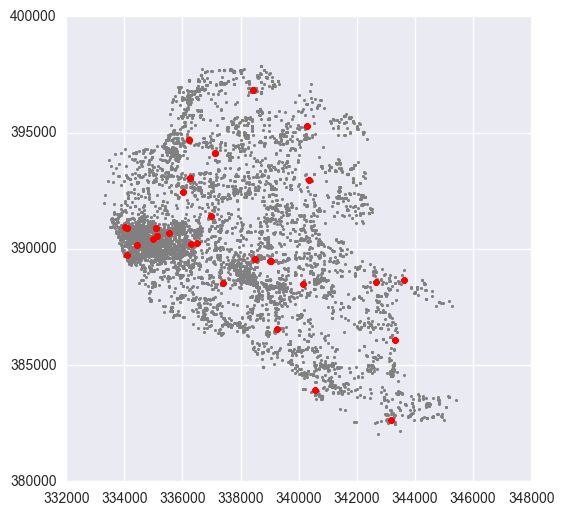

In [20]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Subset points that are not part of any cluster (noise)
noise = tw.loc[lbls==-1, ['X', 'Y']]
# Plot noise in grey
ax.scatter(noise['X'], noise['Y'], c='grey', s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(tw.loc[tw.index.difference(noise.index), 'X'], \
           tw.loc[tw.index.difference(noise.index), 'Y'], \
          c='red', linewidth=0)
# Display the figure
plt.show()

Although informative, the result of this run is not particularly satisfactory. For example, the algorithm misses some clear concentrations in the city centre (left part of the graph) and in the middle of the map, while catching up others that do not apparently look like part of a cluster. This is because we have run `DBSCAN` with the default parameters. If you type `dbscan?`, you will get the help of the function and will be able to see what those are: a radious of 0.5 and a minimum of five points per cluster. Since our data is expressed in metres, a radius of half a metre will only pick up hyper local clusters. This might be of interest in some cases but, in others, it can result in odd outputs. 

Let us change those parameters to see if we can pick up more general patterns. For example, let us say a cluster needs to, at least, have roughly 1% of all the points in the dataset:

In [21]:
# Obtain the number of points 1% of the total represents
minp = np.round(tw.shape[0] * 0.1)
minp

1000.0

At the same time, let us expand the maximum radious to say, 500 metres. Then we can re-run the algorithm and plot the output, all in the same cell this time:

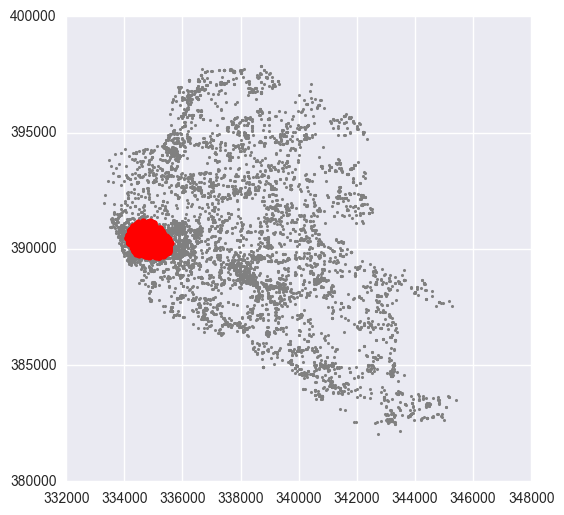

In [22]:
# Rerun DBSCAN
cs, lbls = dbscan(tw[['X', 'Y']], eps=500, min_samples=minp)
# Turn labels into a Series
lbls = pd.Series(lbls, index=tw.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Subset points that are not part of any cluster (noise)
noise = tw.loc[lbls==-1, ['X', 'Y']]
# Plot noise in grey
ax.scatter(noise['X'], noise['Y'], c='grey', s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(tw.loc[tw.index.difference(noise.index), 'X'], \
           tw.loc[tw.index.difference(noise.index), 'Y'], \
          c='red', linewidth=0)
# Display the figure
plt.show()

As we can see, the output now is (very) different: there is a single very large cluster in the city centre. This exemplifies how different parameters can give rise to substantially different outcomes, even if the same data and algorithm are applied.

---

**[Optional exercise]**

Can you create a similar plot as above but, in addition, display also those points that are cores?

---

### Advanced plotting

**NOTE** Please mind this final section of the tutorial is **OPTIONAL**, so do not feel forced to complete it, this will not be covered in the assignment and you will still be able to get a good mark without completing it (also, including any of the following in the assignment does NOT guarantee a better mark).

As we have seen, the choice of parameters plays a crucial role in the number, shape and type of clusters founds in a dataset. To allow an easier exploration of these effects, in this section we will turn the computation and visualization of `DBSCAN` outputs into a single function. This in turn will allow us to build an easy interactive tool later on.

Below is a function that accomplishes just that:

In [23]:
def clusters(db, r, m):
    '''
    Compute and visualize DBSCAN clusters    
    ...
    
    Arguments
    ---------
    db     : (Geo)DataFrame
             Table with at least columns `X` and `Y` for point coordinates
    r      : float
             Maximum radious to search for points within a cluster
    m      : int
             Minimum number of points in a cluster
    '''
    cs, lbls = dbscan(db[['X', 'Y']], eps=r, min_samples=m)
    lbls = pd.Series(lbls, index=db.index)

    f, ax = plt.subplots(1, figsize=(6, 6))
    noise = db.loc[lbls==-1, ['X', 'Y']]
    ax.scatter(noise['X'], noise['Y'], c='grey', s=5, linewidth=0)
    ax.scatter(tw.loc[db.index.difference(noise.index), 'X'], \
               tw.loc[db.index.difference(noise.index), 'Y'], \
              c='red', linewidth=0)
    return plt.show()

The function takes the following three arguments:

1. `db`: a `(Geo)DataFrame` containing the points on which we will try to find the clusters.
1. `r`: a number (maybe with decimals, hence the `float` label in the documentation of the function) specifying the maximum distance to look for neighbors that will be part of a cluster.
1. `m`: a count of the minimum number of points required to form a cluster.

Let us see how the function can be used. For example, let us replicate the plot above, with a minimum of 1% of the points and a maximum radious of 500 metres:

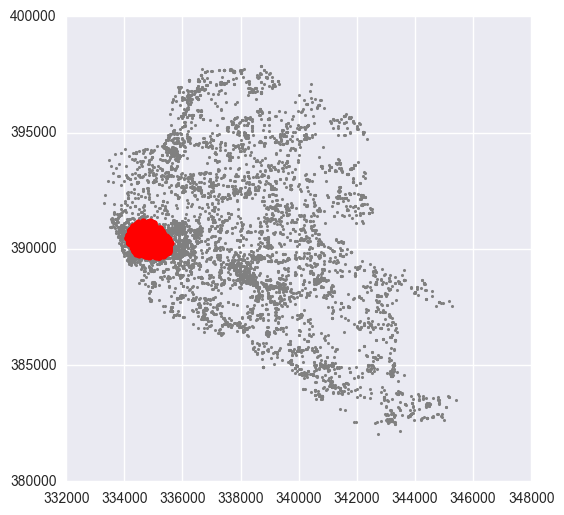

In [24]:
clusters(tw, 500, minp)

Voila! With just one line of code, we can create a map of `DBSCAN` clusters. How cool is that? 

However, this could be even more interesting if we didn't have to write each time the parameters we want to explore. To change that, we can create a quick interactive tool that will allow us to modify both parameters with sliders. To do this, we will use the library [`ipywidgets`](https://ipywidgets.readthedocs.io). Let us first do it and then we will analyse it bit by bit:

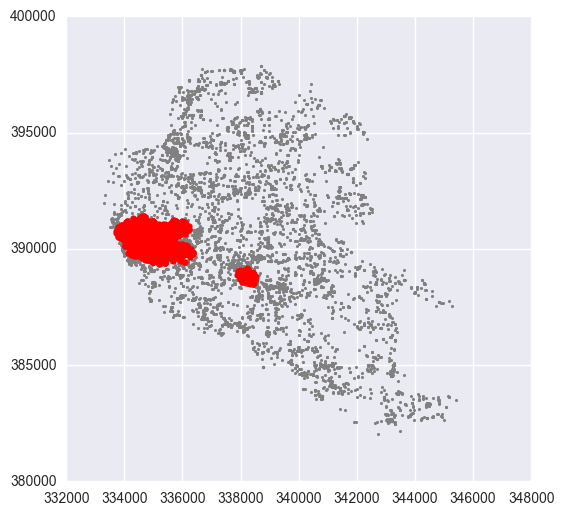

<function __main__.clusters>

In [25]:
interact(clusters, \
        db=fixed(tw), \
        r=(50, 500, 50), \
        m=(50, 300, 50))

Phew! That is cool, isn't it? Once passed the first excitement, let us have a look at how we built it, and how you can modify it further on. A few points on this:

* First, `interact` is a method that allows us to pass an arbitrary function (like `clusters`) and turn it into an interactive widget where we modify the values of its parameters through sliders, drop-down menus, etc.
* What we need to pass to `interact` is the name of the function we would like to make interactive (`clusters` in this case), and all the parameters it will take.
* Since in this case we do not wish to modify the dataset that is used, we pass `tw` as the `db` argument in `clusters` and fixate it by passing it first to the `fixed` method.
* Then both the radious `r` and the minimum cluster size `m` are passed. In this case, we do want to allow interactivity, so we do not use `fixed`. Instead, we pass a tuple that specifies the range and the step of the values we will allow to be used. 
* In the case of `r`, we use `(50, 500, 50)`, which means we want `r` to go from 50 to 500, in jumps of 50 units at a time. Since these are specified in metres, we are saying we want the range to go from 50 to 500 metres in increments of 50 metres.
* In the case of `m`, we take a similar approach and say we want the minimum number of points to go from 50 to 300, in steps of 50 points at a time.

The above results in a little interactive tool that allows us to play easily and quickly with different values for the parameters and to explore how they affect the final outcome.

## Optional exercise (if time permits)

Reproduce the point analysis above with a different dataset of your choice. This involves:

* Obtain the data.
* Load the data in a notebook.
* If you can find a suitable polygon layer to which aggregate the points:
    * Perform a spatial join using QGIS.
    * Aggregate points into the polygon geography by obtaining counts of points per polygon.
    * Create a raw count choropleth.
    * If you have a potential measure of the underlying population, create the ratios and generate a new choropleth.
* Create a Hex binning map of the points.
* Compute and display a kernel density estimate (KDE) of the distribution of the points.
* Obtain clusters using `DBSCAN`.

As a suggestion, you can use the following additional datasets:

* **House transactions** originally provided by the Land Registry.
    * Download a sample for Liverpool from [this link](data/house_transactions.zip).
    * Note that this is really a *marked* point pattern although you will be looking at it as if it was an *unmarked* point pattern. Think of the implications of this in terms of what you can learn about it.
* **Crime data** from [`data.police.uk`](https://data.police.uk/data/).
    * Select the date range you want to download data for.
    * Choose the Police force you want to analyze (for Liverpool, it will be Merseyside. Note this includes an area larger than the municipality).
    * Note that this is a `csv` file, not a shapefile. Use skills learnt in Lab 2 to be able to read it. You can plot the points in the original Coordinate System (lon/lat).
    * Bonus if you figure out how to covert the `DataFrame` into a `GeoDataFrame` and reproject it to the UK grid (`EPSG:27700`). Note this is fairly advanced, so do not despair if you do not get there. A alternative is to read the `csv` file in QGIS and save if as a shapefile there, to be read in Python later on.

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science'16 - Lab 7</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://darribas.org" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

